In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm

In [2]:
dataset = pd.read_parquet("dataset.parquet")
dataset

,chromosome,start,end,transcript_id,score,strand,gene_id,gene_id_count,seq,accession,expression,admixture_group
0,Chr1,1378185,1380185,AT1G04880.1,.,-,AT1G04880,1,GTAAAAGATATCCAGCGTATAATATTGTTTCTTTCCATATATTGAA...,108,0.0,western_europe
1,Chr1,1378185,1380185,AT1G04880.1,.,-,AT1G04880,1,GTAAAAGATATCCAGCGTATAATATTGTTTCTTTCCATATATTGAA...,139,12.0,western_europe
2,Chr1,1378185,1380185,AT1G04880.1,.,-,AT1G04880,1,GTAAAAGATATCCAGCGTATAATATTGTTTCTTTCCATATATTGAA...,159,29.0,western_europe
3,Chr1,1378185,1380185,AT1G04880.1,.,-,AT1G04880,1,GTAAAAGATATCCAGCGTATAATATTGTTTCTTTCCATATATTGAA...,265,8.0,admixed
4,Chr1,1378185,1380185,AT1G04880.1,.,-,AT1G04880,1,GTAAAAGATATCCAGCGTATAATATTGTTTCTTTCCATATATTGAA...,350,86.0,western_europe
...,...,...,...,...,...,...,...,...,...,...,...,...
4650,Chr4,18387732,18389732,AT4G39590.1,.,-,AT4G39590,1,ATATACTCTGGAAAAGGGGAATCGGCTAGGAGAAATCTAAGGGGTT...,10017,1.0,central_europe
4651,Chr4,18387732,18389732,AT4G39590.1,.,-,AT4G39590,1,ATATACTCTGGAAAAGGGGAATCGGCTAGGAGAAATCTAAGGGGTT...,10018,0.0,central_europe
4652,Chr4,18387732,18389732,AT4G39590.1,.,-,AT4G39590,1,ATATACTCTGGAAAAGGGGAATCGGCTAGGAGAAATCTAAAGGGTT...,10020,1.0,central_europe
4653,Chr4,18387732,18389732,AT4G39590.1,.,-,AT4G39590,1,ATATACTCTGGAAAAGGGGAATCGGCTAGGAGAAATCTAAGGGGTT...,10022,0.0,admixed


In [3]:
model_names = [
    "GPN_avgpool_2000",
    "GPN_avgpool_500",
    "GPN_avgpool_100",
    "one_hot",
]
X_dict = {}
for model_name in model_names:
    X_dict[model_name] = np.load(f"embeddings/{model_name}.npy")
 
#X_dict["Concatenation"] = np.hstack([X_dict[model_name] for model_name in model_names])
#model_names.append("Concatenation")

In [4]:
y = np.log(dataset.expression.values+1)
y

array([0.        , 2.56494936, 3.40119738, ..., 0.69314718, 0.        ,
       0.69314718])

In [5]:
def get_score(X, y):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("regression", RidgeCV(cv=10, alphas=np.logspace(-1, 3, 10))),
    ])
    score = cross_val_score(
        model,
        X,
        y,
        scoring=lambda model, X, y: spearmanr(model.predict(X), y).correlation,
        n_jobs=-1,
    ).mean()
    return score

In [6]:
rows = []
for gene_id in tqdm(dataset.gene_id.unique()):
    for model_name in model_names:
        idx_rows = np.where(dataset.gene_id==gene_id)[0]
        score = get_score(X_dict[model_name][idx_rows], y[idx_rows])
        rows.append([gene_id, model_name, score])

100%|██████████| 7/7 [07:37<00:00, 65.34s/it]


In [7]:
results = pd.DataFrame(rows, columns=["gene_id", "model", "spearmanr"])
results

,gene_id,model,spearmanr
0,AT1G04880,GPN_avgpool_2000,-0.008938
1,AT1G04880,GPN_avgpool_500,0.005122
2,AT1G04880,GPN_avgpool_100,0.021515
3,AT1G04880,one_hot,0.009583
4,AT1G09860,GPN_avgpool_2000,0.060213
5,AT1G09860,GPN_avgpool_500,0.063291
6,AT1G09860,GPN_avgpool_100,0.069382
7,AT1G09860,one_hot,0.063677
8,AT1G47920,GPN_avgpool_2000,0.422158
9,AT1G47920,GPN_avgpool_500,0.412789


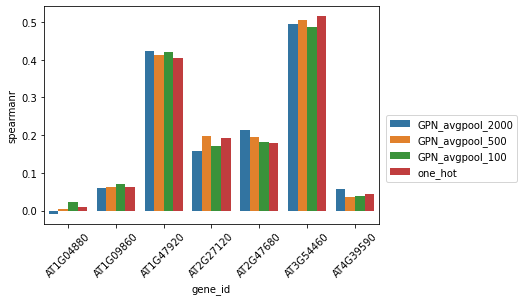

In [13]:
sns.barplot(
    data=results,
    x="gene_id",
    y="spearmanr",
    hue="model",
)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='upper left', borderaxespad=0)

In [8]:
results_pivot = results.pivot(index='gene_id', columns='model', values='spearmanr')
results_pivot

model,GPN_avgpool_100,GPN_avgpool_2000,GPN_avgpool_500,one_hot
gene_id,,,,
AT1G04880,0.021515,-0.008938,0.005122,0.009583
AT1G09860,0.069382,0.060213,0.063291,0.063677
AT1G47920,0.420302,0.422158,0.412789,0.403696
AT2G27120,0.171414,0.158090,0.197778,0.192489
AT2G47680,0.181821,0.213168,0.195041,0.179700
AT3G54460,0.486099,0.494618,0.505119,0.515117
AT4G39590,0.038478,0.056443,0.035815,0.045209


In [14]:
"""plt.figure(figsize=(4, 4))
sns.scatterplot(
    data=results_pivot,
    x="one_hot",
    y="GPN-Avg"
)
plt.plot([results.spearmanr.min(), results.spearmanr.max()], [results.spearmanr.min(), results.spearmanr.max()], color="gray", linestyle="dashed")
plt.axis("equal");"""

'plt.figure(figsize=(4, 4))\nsns.scatterplot(\n    data=results_pivot,\n    x="one_hot",\n    y="GPN-Avg"\n)\nplt.plot([results.spearmanr.min(), results.spearmanr.max()], [results.spearmanr.min(), results.spearmanr.max()], color="gray", linestyle="dashed")\nplt.axis("equal");'